In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import struct

In [11]:
def write_to_output(data_array, file):
    """TODO."""
    file.write(str(data_array[0]))
    if len(data_array) > 1:
        for datum in data_array[1:]:
            file.write(" " + str(datum))
    file.write("\n")
        
def read_from_binary(type_string, file):
    """TODO."""
    return struct.unpack(type_string, file.read(struct.calcsize(type_string)))

class PositReader:
    """TODO."""
    def __init__(self, posit_file):
        """TODO."""
        self.input_file = posit_file
        self.output_file = posit_file + ".hr"
        self.made_hr = False
    
    def make_human_readable(self):
        """TODO."""
        with open(self.input_file, 'rb') as fin, open(self.output_file, 'w+') as fout:
            # Read header: n_steps, n_posit, timestep (int int double)
            header = read_from_binary("iid", fin)

            # Write header
            write_to_output(["n_steps", "n_posit", "delta"], fout)
            write_to_output(header, fout)
            
            # Read body
            write_to_output(["n_particles", "pos_x", "pos_y", "pos_z", "spos_x", "spos_y",
                             "spos_z", "u_x", "u_y", "u_z", "diameter", "length"], fout)
            n_samples = header[0]//header[1]
            for sample in range(n_samples):
                # read number of particles (int), 4 bytes
                num = read_from_binary("i", fin)[0]
                # Read num_particles * posits, each of which are 11 doubles (88 bytes)
                # These correspond to avg_pos (x,y,z), scaled_avg_pos (x,y,z), 
                # orientation (x,y,z), diameter, and length
                try:
                    posits = read_from_binary("ddddddddddd"*num, fin)
                    write_to_output([num] + list(posits), fout)
                except Exception:
                    print("Reached EOF and process terminated early")
                    break
        self.made_hr = True
        
    def get_params_posits(self):
        """TODO."""
        if (self.made_hr):
            params = pd.read_csv(self.output_file, delim_whitespace=True, nrows=1)
            posits = pd.read_csv(self.output_file, skiprows=3, delim_whitespace=True, header=None)
            return params, posits
        else:
            print("Error: PositReader has not yet made human-readable file")
            return None, None


In [12]:
def calc_avg_msd(posits, n_folds=1, every=1):
    """TODO"""
    def calc_msd(x):
        """TODO"""
        result = x.iloc[:, 0:3] - x.iloc[0, 0:3]
        result = result.apply(lambda y: y**2)
        return result.apply(np.sum, axis=1).values
    def calc_vcf(x):
        """TODO"""
        result = x.iloc[:, 6:9] - x.iloc[0, 6:9]
        result = result.apply(lambda y: y**2)
        return result.apply(np.sum, axis=1).values
    
    n_samples = posits.shape[0]
    n_particles = posits.iloc[0, 0]
    n_it = n_samples//n_folds//every
    msds = np.zeros((n_it, n_particles*n_folds))
    vcfs = np.zeros((n_it, n_particles*n_folds))
    tmp = posits.iloc[::every, 1:]
    for fold in range(n_folds):
        msds[:, fold*n_particles:(fold+1)*n_particles] = np.array([calc_msd(
            tmp.iloc[fold*n_it:(fold+1)*n_it, j*11:(j+1)*11]) for j in range(n_particles)]).transpose()
        vcfs[:, fold*n_particles:(fold+1)*n_particles] = np.array([calc_vcf(
            tmp.iloc[fold*n_it:(fold+1)*n_it, j*11:(j+1)*11]) for j in range(n_particles)]).transpose()
    msd = msds.mean(axis=1)
    vcf = vcfs.mean(axis=1)
    msd_err = msds.std(axis=1)/np.sqrt(n_particles*n_folds)
    vcf_err = vcfs.std(axis=1)/np.sqrt(n_particles*n_folds)
    return msd, msd_err, vcf, vcf_err


def calc_msd_theory(params, posits, n_folds=1, every=1):
    """TODO"""
    delta = params.delta[0]
    n_steps = params.n_steps[0]
    length = posits.iloc[0, 11]
    diameter = posits.iloc[0, 10]
    n_samples = posits.shape[0]
    n_it = n_samples//n_folds//every

    t = np.linspace(0, params.delta[0]*(params.n_posit[0])*(n_it*every-1), n_it)

    ### HSK et al. values
    #a = length / diameter + 1
    #lna = np.log(a)
    #friction_par = 2.0 / 3.0 * (length + 1) / (lna - 0.207 + 0.980 / a - 0.133 / (a * a))
    #friction_perp = 4.0 / 3.0 * (length + 1) / (lna + 0.839 + 0.185 / a + 0.233 / (a * a))
    #friction_rot = (length + 1)**3 / (3 * (lna  - 0.662 + 0.917/a -0.050/ (a * a)))
 
    ### Doi & Edwards values
    logLD = np.log(length / diameter)
    friction_perp = 4.0 * length / (3.0 * logLD)
    friction_par = 0.5 * friction_perp
    friction_rot = length**3/(9 * (logLD - 0.8))
    
    ### Montesi et al. values
    #eps = 1.0 / np.log(length / diameter)
    #gamma_0 = 4.0 / 3.0 * eps * ((1 + 0.64 * eps) / (1 - 1.15 * eps) + 1.659 * eps**2)
    #friction_perp = length * gamma_0
    #friction_par = 0.5 * friction_perp
    ### Using same Doi & Edwards value for friction_rot
    #friction_rot = length**3/(9 * (np.log(length / diameter) - 0.8))

    d_com = (1/friction_par + 2/friction_perp) / 3
    d_rot =  1 / friction_rot
    msd_theory = lambda t: 6*d_com*t
    vcf_theory = lambda t: 2*(1 - np.exp(-2*d_rot*t))
    return msd_theory, vcf_theory, t

In [13]:
preader = PositReader('sc_filament_species.posit')
_ = preader.make_human_readable()

In [14]:
params, posits = preader.get_params_posits()

In [19]:
n_folds = 100
msd, msd_err, vcf, vcf_err = calc_avg_msd(posits, n_folds)

In [20]:
msd_theory, vcf_theory, t = calc_msd_theory(params, posits, n_folds)

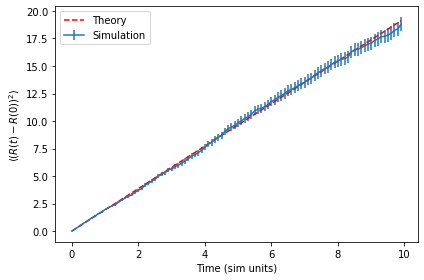

In [21]:
plt.figure()
plt.errorbar(t, msd, yerr=msd_err, label="Simulation")
plt.plot(t, msd_theory(t), 'r--', label="Theory")
plt.legend()
plt.xlabel("Time (sim units)")
plt.ylabel(r"$\langle (R(t) - R(0))^2 \rangle$")
plt.tight_layout()
plt.show()

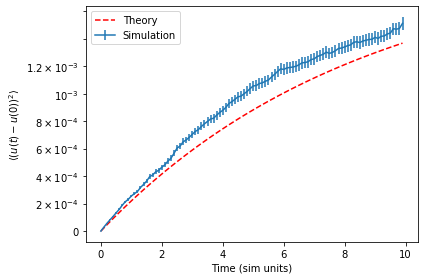

In [22]:
plt.figure()
plt.errorbar(t, vcf, yerr=vcf_err, label="Simulation")
plt.plot(t, vcf_theory(t), 'r--', label="Theory")
plt.legend()
plt.xlabel("Time (sim units)")
plt.ylabel(r"$\langle (u(t) - u(0))^2 \rangle$")
locs, labels = plt.yticks()
new_labels = [
    plt.Text(0,-0.0002,'−0.0002'),
    plt.Text(0,0,'0'),
    plt.Text(0,0.0002,r'$2\times10^{-4}$'),
    plt.Text(0,0.0004,r'$4\times10^{-4}$'),
    plt.Text(0,0.0006,r'$6\times10^{-4}$'),
    plt.Text(0,0.0008,r'$8\times10^{-4}$'),
    plt.Text(0,0.001,r'$10^{-3}$'),
    plt.Text(0,0.0012,r'$1.2\times10^{-3}$'),
    plt.Text(0,0.0014,r'$1.4\times10^{-3}$')
]
plt.yticks(locs[1:-1], new_labels[1:-1])
plt.tight_layout()
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()